#  Notebook Objective

This notebook serves as a **sandbox for experimentation and exploration** of various **time series forecasting techniques**, using the rich and complex dataset from the **Kaggle M5 Forecasting - Accuracy** competition.

The goal is to apply, analyze, and compare different forecasting models—from classical statistical approaches like **ARIMA**, to more advanced machine learning-based methods—in order to better understand sales dynamics and accurately predict future demand.

This notebook is designed to support flexible experimentation at multiple aggregation levels (e.g., by store, by department, or overall), enabling tests of different model configurations, forecasting horizons, and evaluation metrics.

Ultimately, this notebook is envisioned as a **dynamic canvas**, where each code block contributes to building a deeper, more practical understanding of how to tackle real-world forecasting challenges using the M5 dataset as a reference point.




In [58]:
import itertools
import pandas as pd
import numpy as np
from random import gauss, shuffle 
import math


import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

from pmdarima import auto_arima
from pmdarima.arima import ADFTest


from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import os
import lightgbm as lgb

from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 


import warnings
warnings.filterwarnings("ignore")


In [59]:
# load sales data
salesdf = pd.read_csv('sales_train_validation.csv')
salesdf = salesdf.loc[salesdf.state_id == 'CA']
salesdf['id'] = salesdf['item_id'] + '_' + salesdf['store_id'] + '_' + 'validation'
salesdf.head(5)

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,id
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,3,0,1,1,1,3,0,1,1,HOBBIES_1_001_CA_1_validation
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,HOBBIES_1_002_CA_1_validation
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,2,1,1,1,0,1,1,1,HOBBIES_1_003_CA_1_validation
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,5,4,1,0,1,3,7,2,HOBBIES_1_004_CA_1_validation
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,0,1,1,2,2,2,4,HOBBIES_1_005_CA_1_validation


In [60]:
# function to reduce memory usage of a DataFrame, seen on Kaggle

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


salesdf = reduce_mem_usage(salesdf)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


In [61]:
# melt the data into long format
salesdf = pd.melt(salesdf, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()



In [62]:
# get timne series calendar data
caldf = pd.read_csv('calendar.csv')
caldf['d']  = 'd' + '_' + (caldf.index + 1).astype(str)
caldf['date'] = pd.to_datetime(caldf['date'])

In [63]:
# mergfe sales data with calendar data
salesdf = pd.merge(salesdf, caldf, on='d', how='left')
del caldf

* All stores Demand Forecasting per cat

In [64]:
salesdf.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


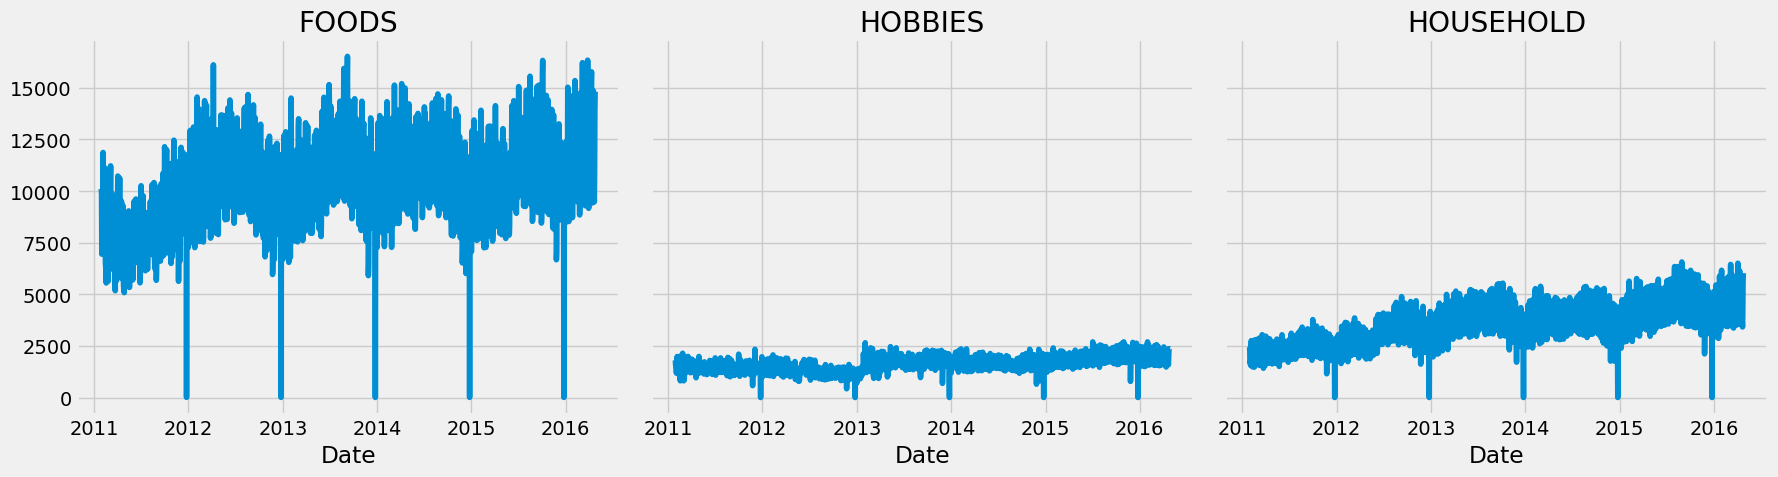

In [65]:
# unique departments

depts = sorted(salesdf['cat_id'].unique())

# create plots for each department
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharex=True, sharey=True)


for i, dept in enumerate(depts):
    salesdf_dept = salesdf[salesdf['cat_id'] == dept]
    sales_by_date = salesdf_dept.groupby('date')['sales'].sum()
    axes[i].plot(sales_by_date.index, sales_by_date.values)
    axes[i].set_title(f'{dept}')
    axes[i].set_xlabel('Date')



plt.tight_layout()
plt.show()

#  Arima Decomposing Foods


In [66]:
# group by date and sum sales for the 'FOODS' category  
ts = salesdf[salesdf['cat_id']=='FOODS'].groupby('date')['sales'].sum()

# ensure the time series is complete by reindexing with a date range
ts = ts.asfreq('D')  

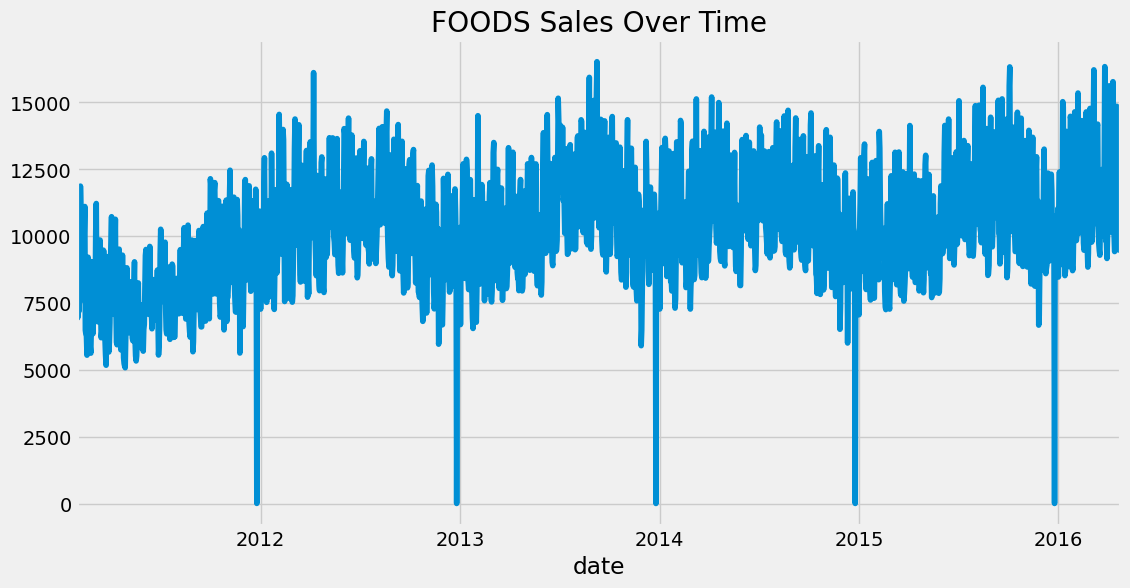

In [67]:

ts.plot(title='FOODS Sales Over Time', figsize=(12, 6))
plt.show()

In [68]:
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)
adf_test = ADFTest(alpha=0.05)
adf_result = adf_test.should_diff(ts)
print(f"ADF Test Result: {adf_result}")

ADF Test Result: (0.01, False)


* P-value = 0.01 shows that the model is stationary

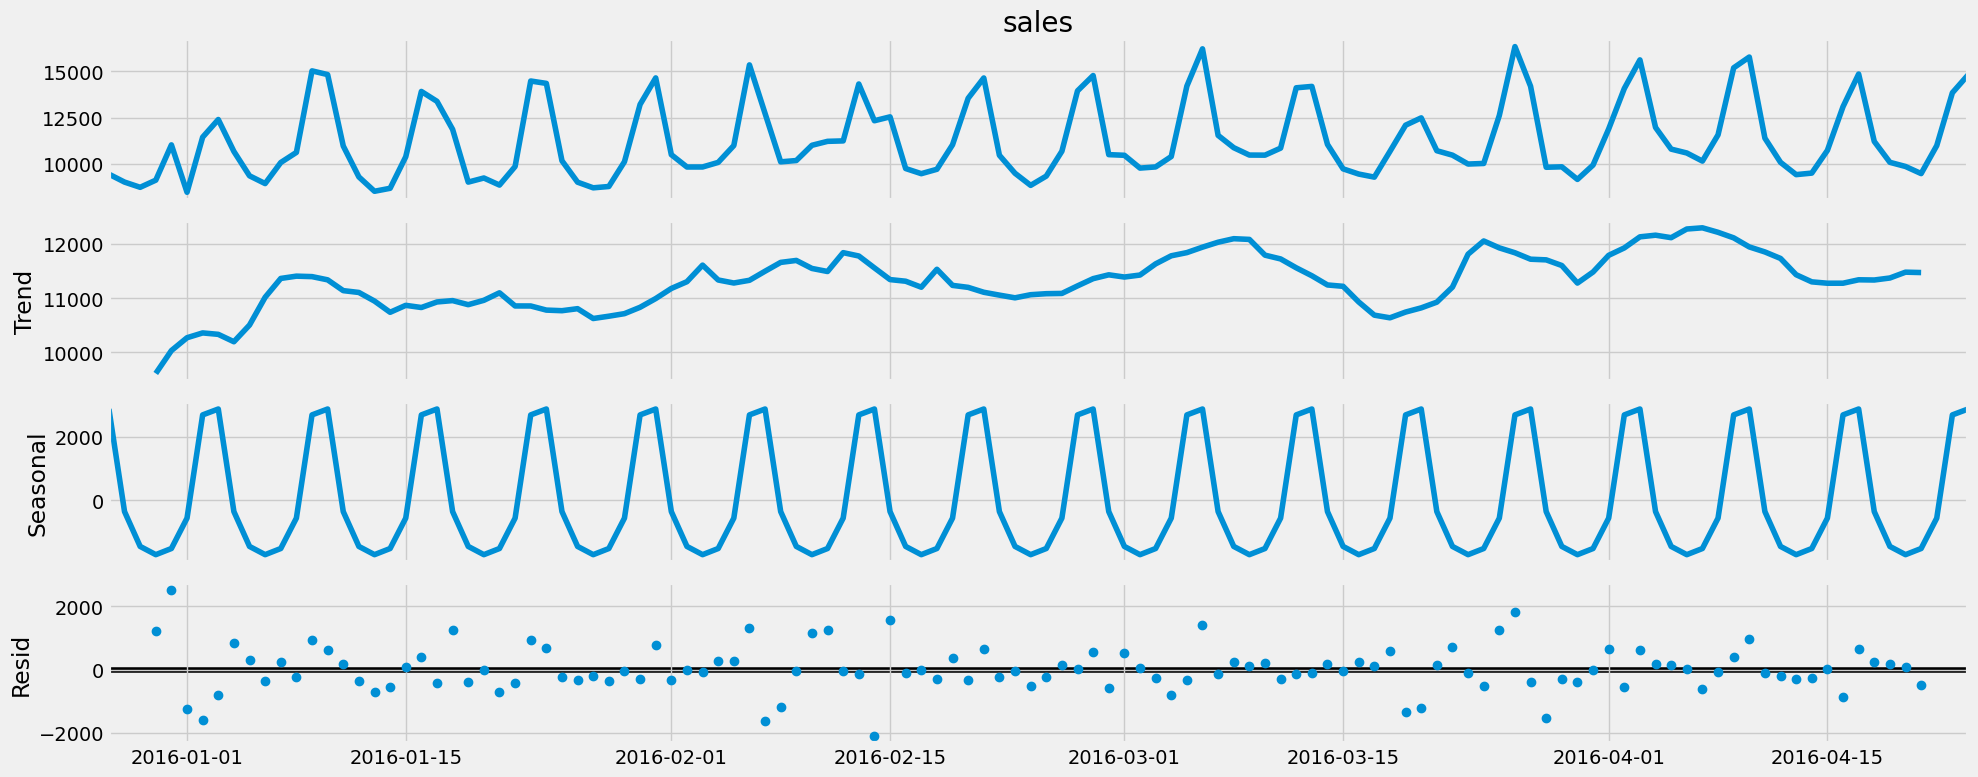

In [69]:


result = seasonal_decompose(ts[-120:], model='additive', period = 7)
fig = result.plot()
fig.set_size_inches(20, 8)
plt.tight_layout()
plt.show()

* Usuing autoarima to forecast


In [70]:
# Data is seasonal, so we will use a seasonal ARIMA model
model_auto = auto_arima(ts[:-28], seasonal=True, trace=True, suppress_warnings=True)
model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32450.229, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33573.495, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33564.200, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33554.661, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33571.498, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32884.446, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32700.841, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=32352.457, Time=0.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=32607.610, Time=0.46 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=31908.428, Time=0.77 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=32451.141, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=31816.002, Time=0.69 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=32143.421, Time=0.20 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=31812.972, Time=0.72 sec
 ARIMA(4,1,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(5, 1, 4)   Log Likelihood              -15830.298
Date:                Fri, 06 Jun 2025   AIC                          31680.595
Time:                        19:58:33   BIC                          31736.007
Sample:                    01-29-2011   HQIC                         31701.003
                         - 03-27-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3547      0.027     13.179      0.000       0.302       0.407
ar.L2         -1.0601      0.023    -46.443      0.000      -1.105      -1.015
ar.L3          0.1333      0.035      3.822      0.000       0.065       0.202
ar.L4         -0.6237      0.018    -35.293      0.000      -0.658      -0.589
ar.L5         -0.4369      0.022    -19.433      0.000      -0.481      -0.393
ma.L1         -0.7852      0.024    -32.819      0.000      -0.832      -0.738
ma.L2          1.2062      0.032     38.272      0.000       1.144       1.268
ma.L3         -0.6448      0.030    -21.393      0.000      -0.704      -0.586
ma.L4          0.7536      0.021     36.528      0.000       0.713       0.794
sigma2      1.383e+06   1.88e+04     73.631      0.000    1.35e+06    1.42e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.58   Jarque-Bera (JB):             25372.20
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -1.54
Prob(H) (two-sided):                  0.01   Kurtosis:                        20.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* auto_arima says theres no seasonality [0] ARIMA(4,1,5)(0,0,0)[0] so we'll test it.

* lets force another model to ddetect stattionality of 7

In [71]:
model_auto_s = auto_arima(ts[:-28], 
                        seasonal=True, 
                        m=7,  # frequency of seasonality (weekly in this case)
                        trace=True, 
                        suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33573.495, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=32371.288, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32983.698, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33571.498, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33564.200, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=32084.102, Time=0.80 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=32275.931, Time=0.48 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=32000.988, Time=0.89 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=32291.621, Time=0.47 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=31898.319, Time=0.91 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=3

* results in  ARIMA(5,1,0)(2,0,0)[7] 

In [72]:
# We left last 28 days for testing, so we will fit the model on the rest of the data
# we use recomendded order from auto_arima
# we will use forced arima model stational 7

forecast_arima = model_auto.predict(n_periods=28)
forecast_sarima = model_auto_s.predict(n_periods=28)



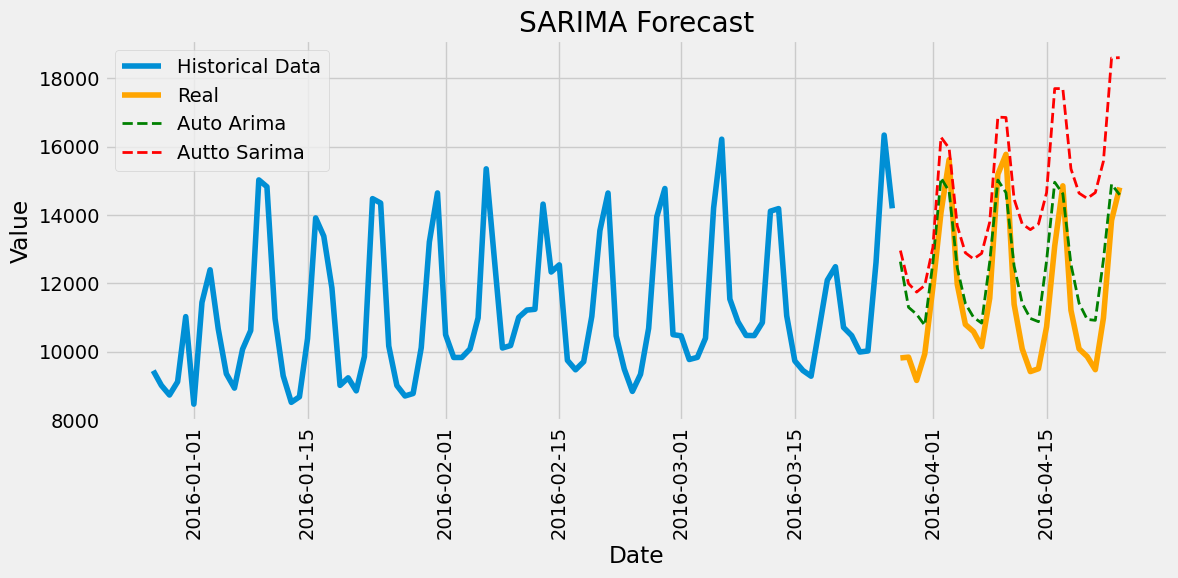

In [73]:
# Plotting Results

plt.figure(figsize=(12, 6))

# Historical data
plt.plot(ts[-120:-28].index, ts[-120:-28].values, label='Historical Data')

# Actual values (last 28 days)
plt.plot(ts[-28:].index, ts[-28:].values, label='Real', color='orange')

# Forecasted values
plt.plot(forecast_arima.index, forecast_arima.values, label='Auto Arima', color='green', linestyle='--', linewidth=2)
plt.plot(forecast_sarima.index, forecast_sarima.values, label='Autto Sarima', color='red', linestyle='--', linewidth=2)


# Labels
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


* We can see auto sarima is adding a false trend.

# Analysing data manually
* From adftest function we establish that the data is stationary.
* Lest try Wiatkowski-Phillips-Schmidt-Shin (KPSS) to verify oir assumtion.

In [74]:
# Perform KPSS test
result = kpss(ts[:-28],regression='ct')

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")



Test Statistic: 1.5041566742393833
P-value: 0.01


* Here we find firts contradiction.
* ADF p-value < 0.05 confirmed stationarity.
* kpps < 0.05 Denies stationarity.
* we'll use differencing to make the series stationary and test

In [75]:


ts_diff = ts.diff().dropna()


result = kpss(ts_diff,regression='ct')

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: 0.021849586243905202
P-value: 0.1


* Now both ADF and KPSS tests indicate that the series is stationary.

* They also suggest that first-order differencing (d=1) is needed to achieve stationarity.

In [76]:



# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 4)  # Autoregressive order
d_values = [1]          # Differencing order from kpss test
q_values = range(0, 4)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 2)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [7]         # Seasonal period weekly

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")  
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = sm.tsa.SARIMAX(ts[:-28], 
                               order=order, 
                               easonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic
        
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            #print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

Best Parameters: (3, 1, 3, 0, 0, 0, 7)
Best AIC: 31974.262955502887


In [77]:
model_sarima2 = sm.tsa.SARIMAX(ts[:-28],
                       order=best_params[:3],
                       seasonal_order=best_params[3:])
result_sarima2 = model_sarima2.fit()

# Show the summary
result_sarima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1885
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -15980.131
Date:                Fri, 06 Jun 2025   AIC                          31974.263
Time:                        19:59:25   BIC                          32013.051
Sample:                    01-29-2011   HQIC                         31988.548
                         - 03-27-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5069      0.029     52.721      0.000       1.451       1.563
ar.L2         -1.3236      0.036    -37.182      0.000      -1.393      -1.254
ar.L3          0.2599      0.028      9.138      0.000       0.204       0.316
ma.L1         -2.1616      0.017   -125.637      0.000      -2.195      -2.128
ma.L2          2.1218      0.025     83.831      0.000       2.072       2.171
ma.L3         -0.9087      0.017    -53.823      0.000      -0.942      -0.876
sigma2      1.846e+06   2.31e-08   8.01e+13      0.000    1.85e+06    1.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.46   Jarque-Bera (JB):             12176.15
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                            -1.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+29. Standard errors may be unstable.
"""

In [78]:
# Forecasting with Manual Sarimas Model
forecast_sarima2 = result_sarima2.get_forecast(steps=28)

forecast_sarima2 = forecast_sarima2.predicted_mean


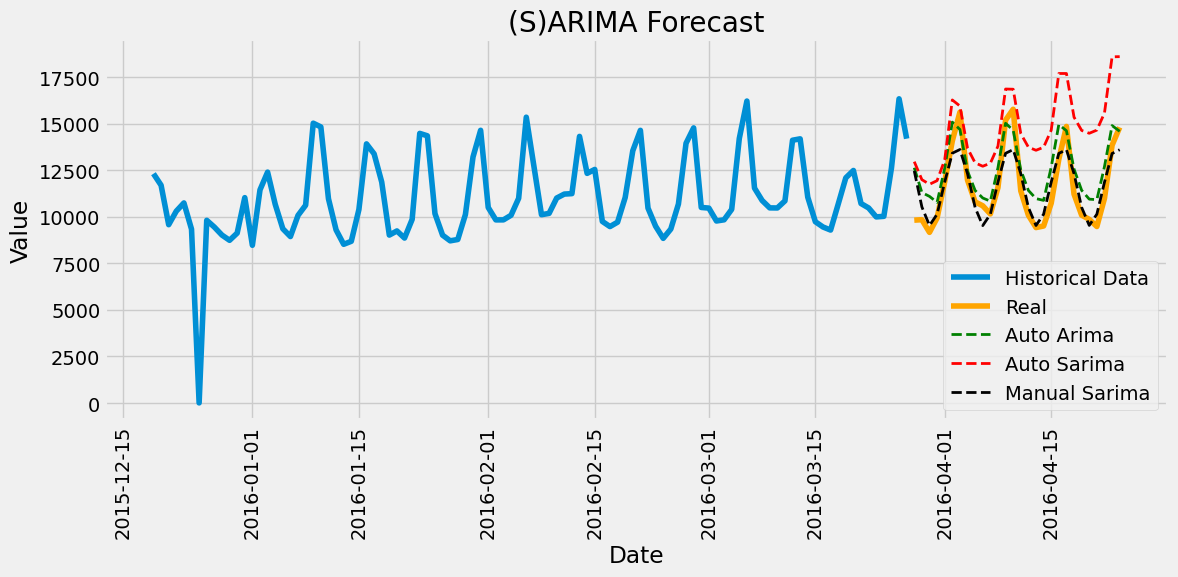

In [79]:
# Integrating manual SARIMA to see the results alongside the auto ARIMA and SARIMA models

plt.figure(figsize=(12, 6))

# Historical data
plt.plot(ts[-128:-28].index, ts[-128:-28].values, label='Historical Data')

# Actual values (last 28 days)
plt.plot(ts[-28:].index, ts[-28:].values, label='Real', color='orange')

# Forecasted values
plt.plot(forecast_arima.index, forecast_arima.values, label='Auto Arima', color='green', linestyle='--', linewidth=2)
plt.plot(forecast_sarima.index, forecast_sarima.values, label='Auto Sarima', color='red', linestyle='--', linewidth=2)
plt.plot(forecast_sarima2.index, forecast_sarima2.values, label='Manual Sarima', color='black', linestyle='--', linewidth=2)



# Labels
plt.title('(S)ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()




In [80]:
# Creating a function to evaluate the forecast
def _evaluate_forecast(actual, forecast):
    """
    Evaluate the forecast using MAPE and RMSE.
    """
    mape_value = np.round(mape(actual, forecast),4)
    rmse_value = np.sqrt(mse(actual, forecast)).round(2)
    
    #print(f'MAPE: {mape_value:.2f}')
    #print(f'RMSE: {rmse_value:.2f}')
    
    return mape_value, rmse_value

In [81]:
model_forecasts = [
    ('Auto Arima', forecast_arima.values),
    ('Auto Sarima', forecast_sarima.values),
    ('Manual Sarima', forecast_sarima2.values)
]

results = []
for name, forecast in model_forecasts:
    mape_value, rmse_value = _evaluate_forecast(ts[-28:].values, forecast)
    results.append({'Model': name, 'MAPE': mape_value, 'RMSE': rmse_value})

dfresults = pd.DataFrame(results)
dfresults

,Model,MAPE,RMSE
0,Auto Arima,0.1049,1282.76
1,Auto Sarima,0.2768,3306.78
2,Manual Sarima,0.0665,1036.43


# So in just a few steps we were able to outperform auto arima models by ~ 4%, wich doesn't seem to be a lot, but its ~ 200 units per day.

* i'll use another notebook

In [82]:
# Check for unique categories in the categorical columns

cats = ['cat_id', 'store_id']

for col in cats:
    print(f'Column: {col}',salesdf[col].unique())

Column: cat_id ['HOBBIES', 'HOUSEHOLD', 'FOODS']
Categories (3, object): ['FOODS', 'HOBBIES', 'HOUSEHOLD']
Column: store_id ['CA_1', 'CA_2', 'CA_3', 'CA_4']
Categories (4, object): ['CA_1', 'CA_2', 'CA_3', 'CA_4']


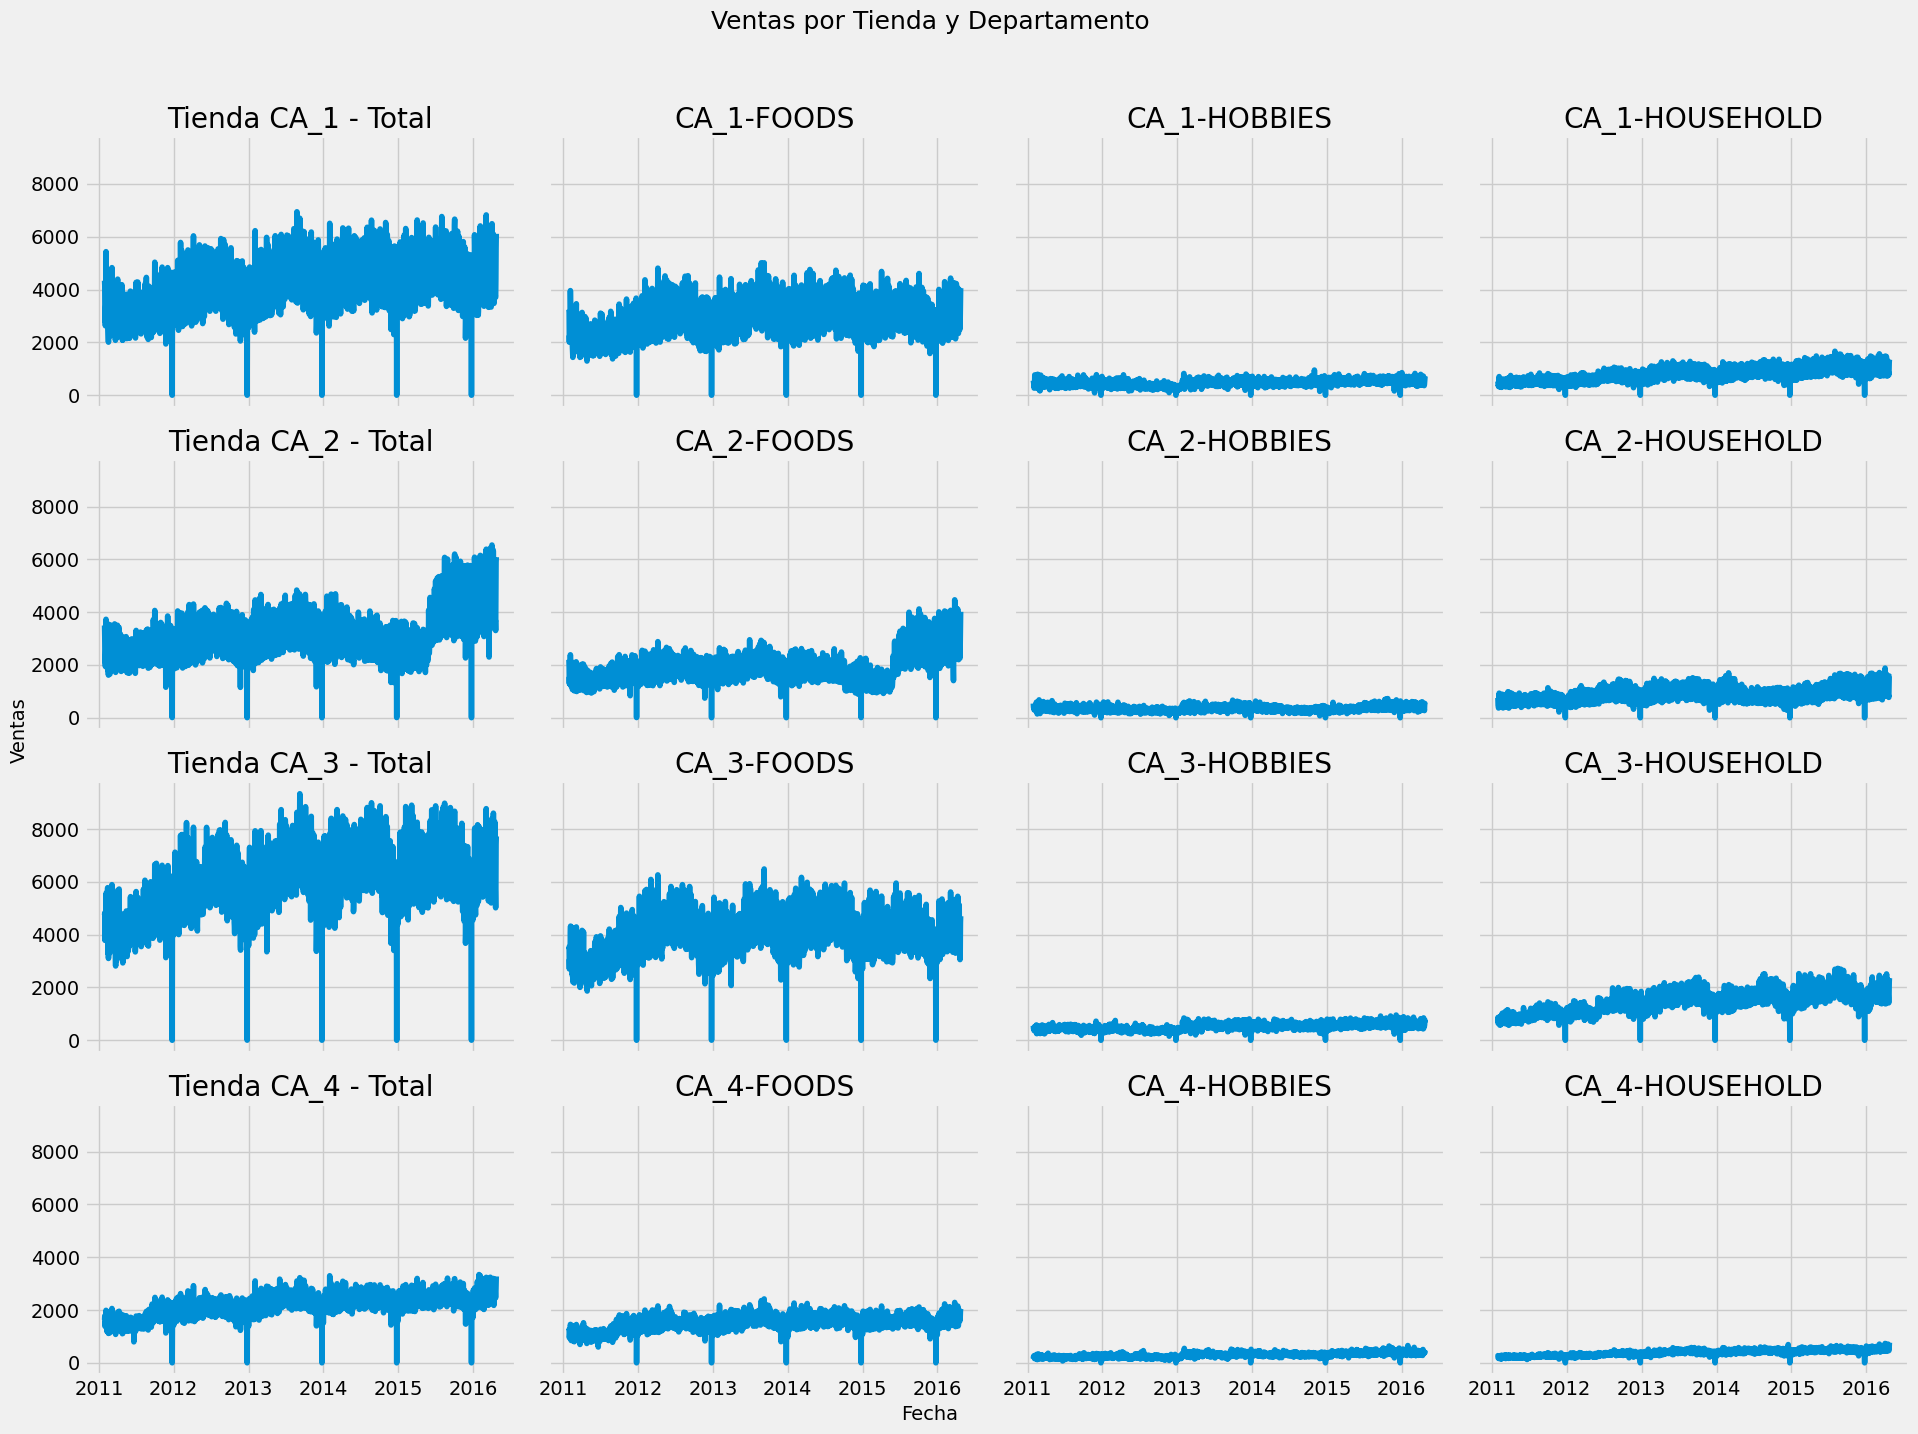

In [83]:
# plotting  sales per store per cat


stores = sorted(salesdf['store_id'].unique())
depts = sorted(salesdf['cat_id'].unique())

# Crear el subplot 4x4
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15), sharex=True, sharey=True)

for i, store in enumerate(stores):
    # Fila i, Columna 0 → todos los departamentos (ventas totales por tienda)
    salesdf_store = salesdf[salesdf['store_id'] == store]
    total_sales = salesdf_store.groupby('date')['sales'].sum()
    axes[i, 0].plot(total_sales.index, total_sales.values)
    axes[i, 0].set_title(f'Tienda {store} - Total')
    
    # Columnas 1 a 3 → ventas por departamento
    for j, dept in enumerate(depts):
        salesdf_sd = salesdf_store[salesdf_store['cat_id'] == dept]
        sales = salesdf_sd.groupby('date')['sales'].sum()
        axes[i, j+1].plot(sales.index, sales.values)
        axes[i, j+1].set_title(f'{store}-{dept}')

# Etiquetas generales
fig.suptitle('Ventas por Tienda y Departamento', fontsize=18)
fig.text(0.5, 0.04, 'Fecha', ha='center')
fig.text(0.04, 0.5, 'Ventas', va='center', rotation='vertical')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()